In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import os, sys
import numpy as np
import pandas as pd
from operator import itemgetter
from IPython.display import display
from matplotlib import pyplot as plt
sys.path.append(os.path.abspath(os.path.join('../..')))

from database.CERNMongoClient import CERNMongoClient
from preprocessing import builder
from preprocessing.fourier_transform import _intensity_max_var, _intensity_max_all, _intensity_median, _frequency_max, \
    _frequency_percentage_intensity5, _frequency_percentage_intensity10, _frequency_percentage_intensity20, fft_ft
from preprocessing import fourier_transform
import plot.data
# auto-load changes in imported modules
%autoreload 2

## Explore data

In [3]:
start = pd.to_datetime("2017-05-15 00:00:00")
end = pd.to_datetime("2017-06-15 00:00:00")
beam = 1
var = 'MKI.D5L2.B1:PRESSURE'
db = CERNMongoClient()

In [4]:
pressure = db.query(var, start, end, resample_to='1min')

Fetching data for pattern MKI.D5L2.B1:PRESSURE from 2017-05-15 00:00:00 to 2017-06-15 00:00:00



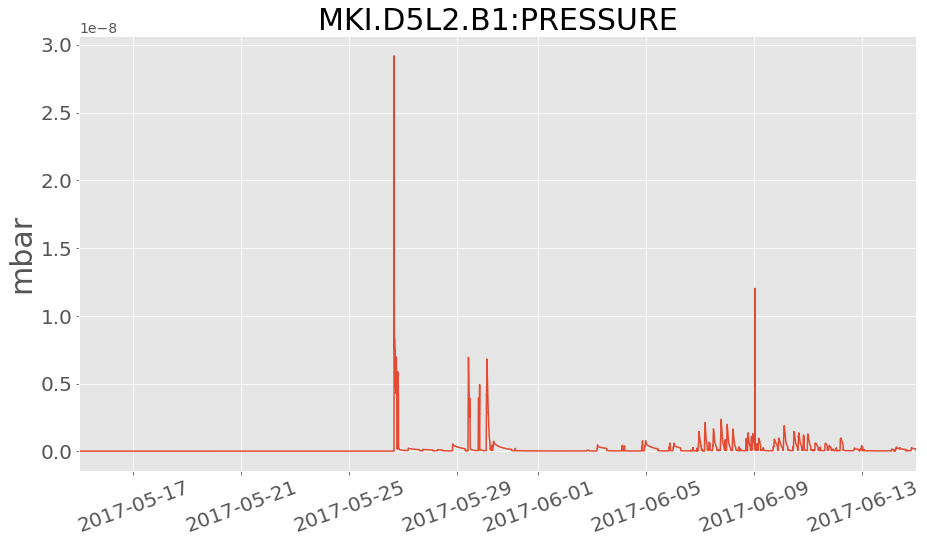

In [15]:
plt.plot(pressure.index, pressure)
plt.xticks(rotation=20)
plt.xlim([pressure.index.min(), pressure.index.max()])
plt.ylabel('mbar', fontsize=30)
plt.tick_params(labelsize=20)
plt.title('MKI.D5L2.B1:PRESSURE',fontsize=30)
plt.savefig('spectrogram_input.pdf')

## Create spectrogram

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html

In [16]:
from scipy import signal, stats
import matplotlib.pyplot as plt

In [17]:
x = pressure[var]
display(x.head())
display(x.tail())
print(type(x))

timestamps
2017-05-15 00:13:00    2.300000e-11
2017-05-15 00:14:00    2.300000e-11
2017-05-15 00:15:00    2.300000e-11
2017-05-15 00:16:00    2.300000e-11
2017-05-15 00:17:00    2.300000e-11
Freq: T, Name: MKI.D5L2.B1:PRESSURE, dtype: float64

timestamps
2017-06-14 23:52:00    7.200000e-11
2017-06-14 23:53:00    6.700000e-11
2017-06-14 23:54:00    6.700000e-11
2017-06-14 23:55:00    6.700000e-11
2017-06-14 23:56:00    6.200000e-11
Freq: T, Name: MKI.D5L2.B1:PRESSURE, dtype: float64

<class 'pandas.core.series.Series'>


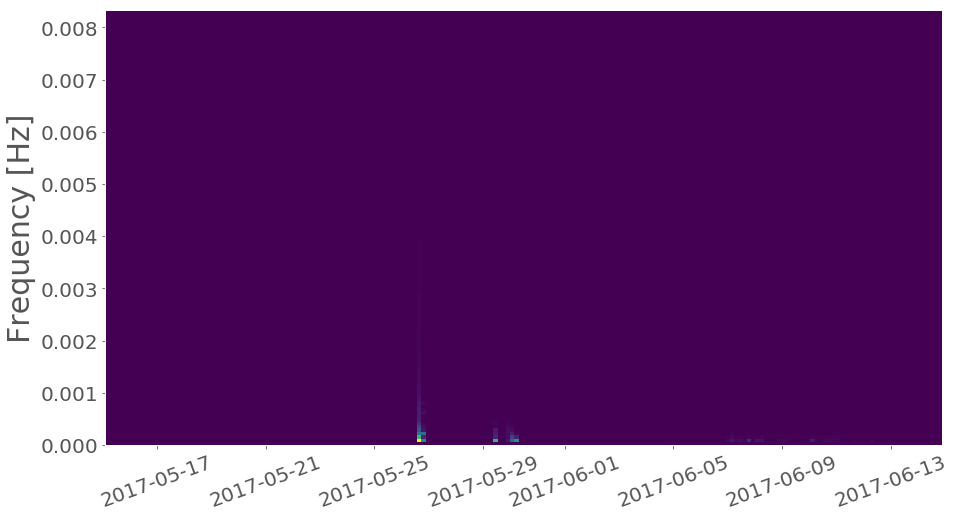

In [19]:
fs = 1./60
f, t, Sxx = signal.spectrogram(x, fs)
t = pd.to_datetime(t, unit="s", origin=start)
plt.pcolormesh(t, f, Sxx)
plt.xticks(rotation=20)
plt.ylabel('Frequency [Hz]', fontsize=30)
plt.tick_params(labelsize=20)
plt.axis([t.min(),t.max(),f.min(),f.max()])
plt.savefig('spectrogram1.pdf')
plt.show()

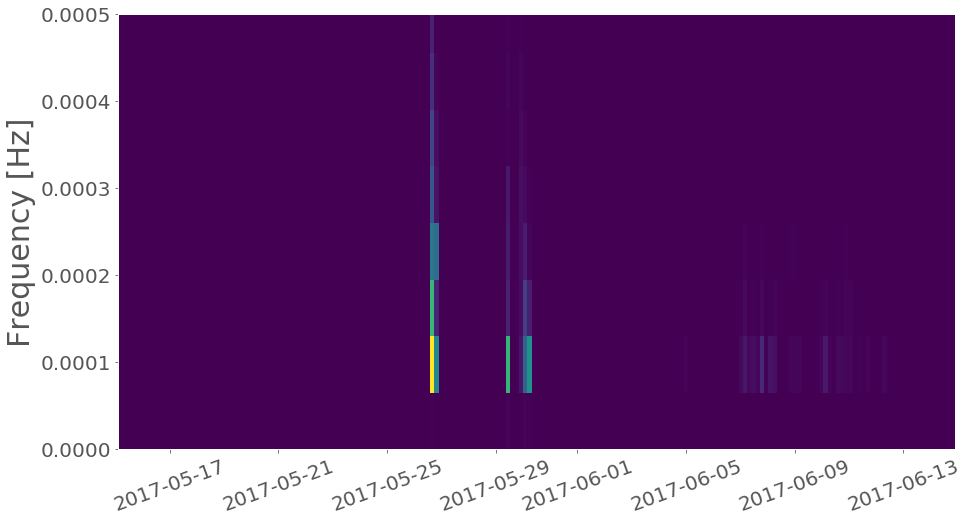

In [20]:
# zoom in 
plt.pcolormesh(t, f, Sxx)
plt.xticks(rotation=20)
plt.ylabel('Frequency [Hz]', fontsize=30)
plt.axis([t.min(),t.max(),0.000, 0.0005])
plt.tick_params(labelsize=20)
plt.savefig('spectrogram2.pdf')
plt.show()

## Example call

In [21]:
data = db.query(var, start, end, resample_to="1min")
features = pd.DataFrame()
fs = 1/(60*1)
features = features.join(fft_ft(data, start, fs, '_fft_int_max_var', _intensity_max_var),
                             how='outer')
features = features.join(fft_ft(data, start, fs, '_fft_int_max_all', _intensity_max_all),
                         how='outer')
features = features.join(fft_ft(data, start, fs, '_fft_int_median', _intensity_median),
                         how='outer')
features = features.join(fft_ft(data, start, fs, '_fft_freq_max', _frequency_max), how='outer')
features = features.join(fft_ft(data, start, fs, '_fft_freq_percentage_intensity5',
                                _frequency_percentage_intensity5), how='outer')
features = features.join(fft_ft(data, start, fs, '_fft_freq_percentage_intensity10',
                                _frequency_percentage_intensity10), how='outer')
features = features.join(fft_ft(data, start, fs, '_fft_freq_percentage_intensity20',
                                _frequency_percentage_intensity20), how='outer')

Fetching data for pattern MKI.D5L2.B1:PRESSURE from 2017-05-15 00:00:00 to 2017-06-15 00:00:00



<Figure size 1080x576 with 0 Axes>

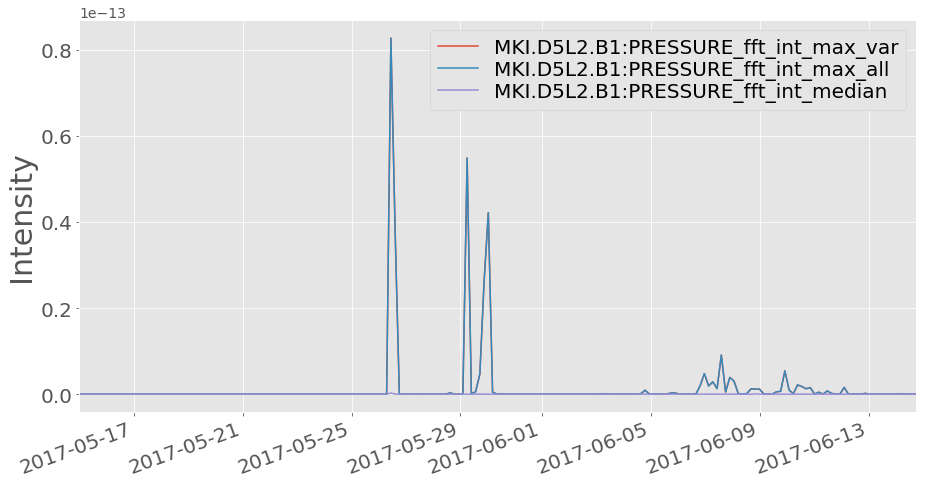

In [34]:
fig = plt.figure()
ax = features[['MKI.D5L2.B1:PRESSURE_fft_int_max_var','MKI.D5L2.B1:PRESSURE_fft_int_max_all','MKI.D5L2.B1:PRESSURE_fft_int_median']].plot(rot=20)
ax.set_ylabel('Intensity',fontsize=30)
ax.set_xlabel('')
fig = ax.get_figure()
prop={'size': 6}
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
fig.savefig('spectrogram_intensity.pdf')

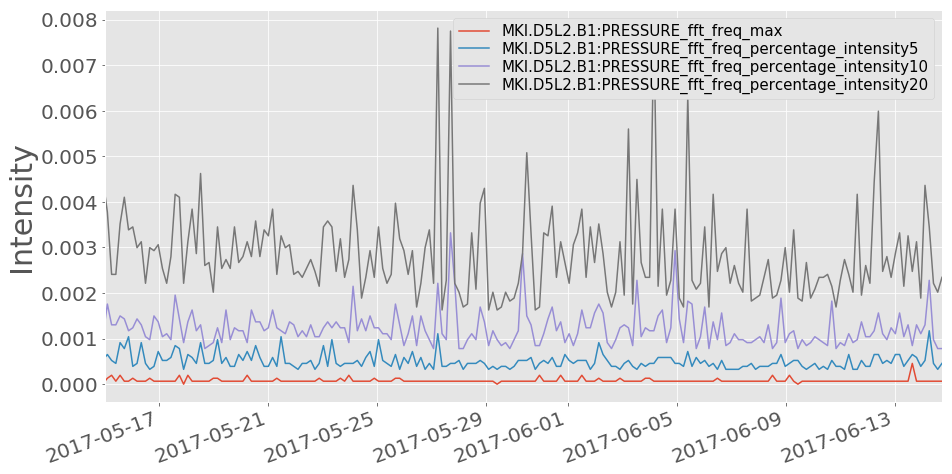

In [37]:
ax = features[['MKI.D5L2.B1:PRESSURE_fft_freq_max','MKI.D5L2.B1:PRESSURE_fft_freq_percentage_intensity5','MKI.D5L2.B1:PRESSURE_fft_freq_percentage_intensity10','MKI.D5L2.B1:PRESSURE_fft_freq_percentage_intensity20']].plot(rot=20)
ax.set_ylabel('Intensity',fontsize=30)
ax.set_xlabel('')
fig = ax.get_figure()
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 15})
fig.savefig('spectrogram_frequency.pdf')